In [10]:
#..........................案例1:
#..........................bagging：基于数据随机重抽样的分类器构建方法，每个分类器是等权重的。更先进的bagging方法，随机森林
#..........................boosting是一种与bagging很类似的技术，但是boosting不同的分类器是通过串行训练而获得的，每个新分类器都根据已训练出的分类器的性能来进行训练。boosting是通过集中关注被已有分类器错分的那些数据来获得新的分类器。它的分类器的权重是不同的，每个权重代表的是其对应分类器在上一轮迭代中的成功度。
#..............AdaBoost（adaptive boosting）是boosting的一种
#..............AdaBoost在同一样本多次操作，每个样本的权重alpha=0.5*ln(1/u-1)，u=error/all。即越错权重越大
#......

import numpy as np
datMat = np.mat([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
# 通过阈值进行分类
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
# 循环找到具有最低错误率的单层决策树，基于加权输入值进行决策的分类器
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal) #call stump classify with i, j, lessThan
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst
# bestStump的空字典，这个字典用于存储给定权重向量D时所得到的最佳单层决策树的相关信息
# minError 错误率
# bestClasEst 类别估计值
D=np.mat(np.ones((5,1))/5) # 每一个数据点的权重
print(buildStump(datMat,classLabels,D))
# adaboost训练
def adaBoostTrainDS(dataArr,classLabels,numIt=40): # 最大迭代次数
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print "D:",D.T
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        # print("aggClassEst: ",aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst
print('训练结果：\n',adaBoostTrainDS(datMat,classLabels,numIt=40))
classr=adaBoostTrainDS(datMat,classLabels,numIt=40)
# AdaBoost分类函数
def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],classifierArr[i]['thresh'],classifierArr[i]['ineq']) # call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        # print(aggClassEst)
    return np.sign(aggClassEst)
print('预测结果：\n',adaClassify([0,0],classr[0]))

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.]]))
total error:  0.2
total error:  0.2
total error:  0.0
训练结果：
 ([{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}], matrix([[ 1.17568763],
        [ 2.56198199],
        [-0.77022252],
        [-0.77022252],
        [ 0.61607184]]))
total error:  0.2
total error:  0.2
total error:  0.0
预测结果：
 [[-1.]]


In [11]:
#..........................案例2:
#..........................实际应用
import pandas as pd
file=r'C:\Users\Wudey\Desktop\machinelearninginaction\Ch07\horseColicTraining2.txt'
file1=r'C:\Users\Wudey\Desktop\machinelearninginaction\Ch07\horseColicTest2.txt'
dta=pd.read_table(file,header=None)
dta,label=dta.iloc[:,:-1],dta.iloc[:,-1]
classr=adaBoostTrainDS(dta,label,10) # 10在一定程度上代表了分类器的个数
dta1=pd.read_table(file1,header=None)
dta1,label1=dta1.iloc[:,:-1],dta1.iloc[:,-1]
pre=adaClassify(dta1,classr[0])
err=np.mat(np.ones((67,1)))
print("错误率：",err[pre!=np.mat(label1).T].sum()/67)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078
错误率： 0.23880597014925373


total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078
the Area Under the Curve is:  0.8582969635063604


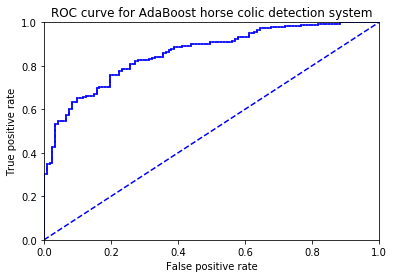

In [12]:
#..........................案例3:
#..........................分类效果判断
#............混淆矩阵：
#...         +1(预测)                   -1(预测)
#... +1 真正例（TP，true positive）   伪反例（FN，false negative）
#... -1 伪正例（FP）                  真反例（TN）
#... 正确率（Precision），它等于TP/(TP+FP)，预测+1中有多少是对的（预测对的中对多少）
#... 召回率（Recall），它等于TP/(TP+FN)，真实+1中有多少是预测对的（对的中预测对的）
#... ROC曲线（曲线下面积越大越好）：
# 横轴：假阳率=FP/(FP+TN) 错的中预测错的 类似于cost
# 纵轴：真阳率=TP/(TP+FN) 召回率 类似于benefit
# ROC曲线的绘制及AUC计算函数
# 为了画出ROC曲线，分类器必须提供每个样例被判为阳性或者阴性的可信程度值，adaBoostTrainDS的输出agg即为所需
import matplotlib.pyplot as plt
def plotROC(predStrengths, classLabels):
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort() #get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep
        else:
            delX = xStep; delY = 0
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)
classr,agg=adaBoostTrainDS(dta,label,10)
plotROC(agg.T,label)

# 过均衡
# 假设正例和反例非常不平衡，如50:1，可以考虑删除部分正例和复制部分反例